## Environment Setting

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install dominate==2.4.0
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
!conda install -c conda-forge opencv==4.1.0

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 62.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 276kB 10.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=be1abfbb65dfa6a50f4445c7ce546c7772567726dea4333821a19a17782391c9
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pi

## Clone the file from Gihub

In [2]:
!git clone https://github.com/ericsujw/InstColorization.git

Cloning into 'InstColorization'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 211 (delta 0), reused 2 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 6.11 MiB | 43.47 MiB/s, done.
Resolving deltas: 100% (78/78), done.


## Start Colorization

In [3]:
cd InstColorization/

/content/InstColorization


## Download the Model

In [4]:
!sh scripts/download_model.sh

Downloading...
Finish download.
Archive:  checkpoints.zip
   creating: checkpoints/coco_finetuned_mask_256_ffs/
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth  
   creating: checkpoints/coco_finetuned_mask_256/
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GF.pth  
   creating: checkpoints/siggraph_retrained/
  inflating: checkpoints/siggraph_retrained/latest_net_G.pth  


### Detect Object bounding box


Setting the Detectron2.

In [5]:
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_2d9806.pkl: 431MB [00:18, 23.0MB/s]                           


In [6]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/MyDrive/colab tmp/images' '/content/InstColorization/' -r
!rm -r example
!mv images example

Mounted at /content/drive


Let's create a bounding box folder to save our prediction results.

In [7]:
input_dir = "example"
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

Create path: images_bbox


Here we simply take L channel as our input and make sure that we can get consistent box prediction results even though the original image is color images.

In [8]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

Now we have all the images' prediction results.

In [10]:
!ls images_bbox

000000022969.npz  000000046872.npz	      5951960966_d4e1cda5d0_z.npz
000000023781.npz  262985539_1709e54576_z.npz  8053677163_d4c8f416be_z.npz


### Colorize Images

We first set up some libraries and options

In [11]:
import sys
import time
from options.train_options import TestOptions
from models import create_model

import torch
from tqdm import tqdm_notebook

from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

torch.backends.cudnn.benchmark = True

sys.argv = [sys.argv[0]]
opt = TestOptions().parse()

Then we need to create a results folder to save our predicted color images and read the dataset loader.

In [13]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
dataset = Fusion_Testing_Dataset(opt, -1)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

#Testing images = 6


Load the pre-trained model.

In [14]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


Start to colorize every images in `dataset_loader`.

In [15]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



0 images without bounding boxes


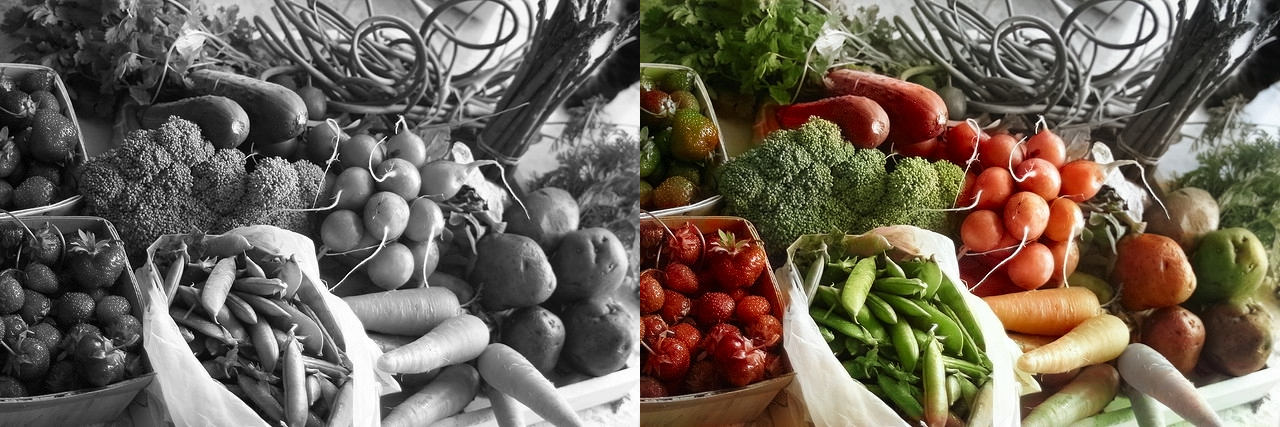

In [16]:
from google.colab.patches import cv2_imshow
img_name_list = ['000000022969', '000000023781', '000000046872', '000000050145']
show_index = 1

img = cv2.imread('example/'+img_name_list[show_index]+'.jpg')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, _, _ = cv2.split(lab_image)

img = cv2.imread('results/'+img_name_list[show_index]+'.png')
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
_, a_pred, b_pred = cv2.split(lab_image)
a_pred = cv2.resize(a_pred, (l_channel.shape[1], l_channel.shape[0]))
b_pred = cv2.resize(b_pred, (l_channel.shape[1], l_channel.shape[0]))
gray_color = np.ones_like(a_pred) * 128

gray_image = cv2.cvtColor(np.stack([l_channel, gray_color, gray_color], 2), cv2.COLOR_LAB2BGR)
color_image = cv2.cvtColor(np.stack([l_channel, a_pred, b_pred], 2), cv2.COLOR_LAB2BGR)

# save_img_path = 'results_origin/'
# if os.path.isdir(save_img_path) is False:
#     print('Create path: {0}'.format(save_img_path))
#     os.makedirs(save_img_path)

# cv2.imwrite('results_origin/'+img_name_list[show_index]+'.png', color_image)

cv2_imshow(np.concatenate([gray_image, color_image], 1))